In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Word2vec
import gensim

# Utility
import re
import string
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DATASET
DATASET_COLUMNS = ["TWID","TEXT","VALUE"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 320
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 320
EPOCHS = 50
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/etd_full.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING ,
                 lineterminator='\n')
df = df.sample(20000)

Open file: /content/drive/MyDrive/Colab Notebooks/etd_full.csv


In [ ]:
print("Dataset size:", len(df))

Dataset size: 20000


In [ ]:
df.head(10)

,TWID,TEXT,VALUE
250411,1.983216e+09,Can't believe it's already 3 pm on Sunday. Wh...,-1
698874,2.254265e+09,back home via nan's. no broken bones. just sof...,-1
212844,1.974846e+09,Grrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr I was bac...,-1
2125202,7.830479e+17,MT @SaharahShae: One of the most beautiful sig...,1
108964,1.824427e+09,HELLO ALL TWITTERS!! I've missed u. Been away ...,-1
692865,2.252591e+09,i don't think i'll b able 2 tweet 4 a while cu...,-1
2214917,7.961776e+17,Nintendo Game Boy Advance SP Cobalt Blue w/ Ex...,0
266417,1.988987e+09,I have to make a drs appt. Looks like i have a...,-1
2207938,7.960349e+17,I'm having some apple pie in between making ca...,0
1562887,2.186931e+09,"@KaraSaysSo huh? Oh, it's a scheme about how t...",1


In [ ]:
decode_map = {-1: "NEGATIVE", 1: "POSITIVE", 0: "NEUTRAL"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.VALUE = df.VALUE.apply(lambda x: decode_sentiment(x))

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 12.8 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

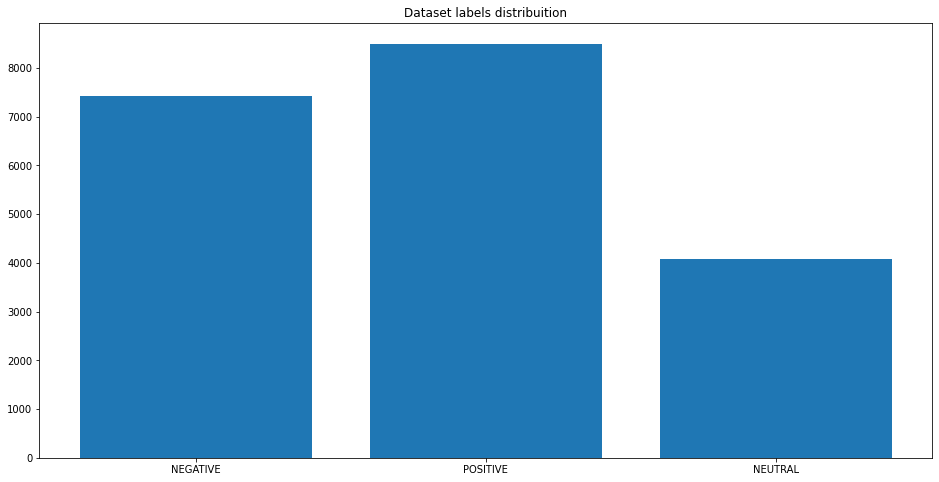

In [ ]:
target_cnt = Counter(df.VALUE)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
df.TEXT.head(10)

250411     Can't believe it's already 3 pm on Sunday.  Wh...
698874     back home via nan's. no broken bones. just sof...
212844     Grrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr I was bac...
2125202    MT @SaharahShae: One of the most beautiful sig...
108964     HELLO ALL TWITTERS!! I've missed u. Been away ...
692865     i don't think i'll b able 2 tweet 4 a while cu...
2214917    Nintendo Game Boy Advance SP Cobalt Blue w/ Ex...
266417     I have to make a drs appt. Looks like i have a...
2207938    I'm having some apple pie in between making ca...
1562887    @KaraSaysSo huh? Oh, it's a scheme about how t...
Name: TEXT, dtype: object

In [ ]:
# split train, test data 
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 16000
TEST size: 4000


In [ ]:
df_train.head()

,TWID,TEXT,VALUE
2440557,8.021403e+17,#Ebolanurse suspended after falsifying #Paulin...,NEGATIVE
197405,1.970991e+09,Just dropped Laura off at the ATL airport to g...,NEGATIVE
1624509,NaN,Cut through the layers of soap-opera emotion,NEUTRAL
2540901,5.123168e+17,I just found a Swag Code worth 3 Swag Bucks. h...,NEUTRAL
1882868,7.684654e+17,RT @Chellaney: Japan's 7th-generation shinkans...,NEUTRAL


In [ ]:
# tokenization
documents = [_text.split() for _text in df_train.TEXT]

In [ ]:
# cleaning token
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token

# processing
def process_token(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        # Eliminating the token if it is not characters in English
        token = re.sub("([^A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

In [ ]:
print(documents[4])

['RT', '@Chellaney:', "Japan's", '7th-generation', 'shinkansen', 'bullet', 'train', 'will', 'be', '30%', 'lighter', 'and', 'could', 'be', 'introduced', 'on', 'Dallas-Houston', 'route', 'https://tâ\x80¦']


In [ ]:
print(process_token(documents[4]))

['rt', 'japans', '7thgeneration', 'shinkansen', 'bullet', 'train', 'will', 'be', '30', 'lighter', 'and', 'could', 'be', 'introduced', 'on', 'dallashouston', 'route']


In [ ]:
cleaned_documents = [process_token(document) for document in documents]

In [ ]:
print(cleaned_documents[4])

['rt', 'japans', '7thgeneration', 'shinkansen', 'bullet', 'train', 'will', 'be', '30', 'lighter', 'and', 'could', 'be', 'introduced', 'on', 'dallashouston', 'route']


In [ ]:
# word 2 vec
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2020-12-01 11:29:44,299 : INFO : collecting all words and their counts
2020-12-01 11:29:44,303 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-01 11:29:44,352 : INFO : PROGRESS: at sentence #10000, processed 128111 words, keeping 37515 word types
2020-12-01 11:29:44,376 : INFO : collected 54693 word types from a corpus of 205142 raw words and 16000 sentences
2020-12-01 11:29:44,377 : INFO : Loading a fresh vocabulary
2020-12-01 11:29:44,402 : INFO : effective_min_count=10 retains 1860 unique words (3% of original 54693, drops 52833)
2020-12-01 11:29:44,404 : INFO : effective_min_count=10 leaves 130057 word corpus (63% of original 205142, drops 75085)
2020-12-01 11:29:44,416 : INFO : deleting the raw counts dictionary of 54693 items
2020-12-01 11:29:44,419 : INFO : sample=0.001 downsamples 56 most-common words
2020-12-01 11:29:44,420 : INFO : downsampling leaves estimated 96577 word corpus (74.3% of prior 130057)
2020-12-01 11:29:44,430 : INFO : estima

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1860


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-12-01 11:29:51,188 : INFO : training model with 8 workers on 1860 vocabulary and 320 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-12-01 11:29:51,399 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 11:29:51,405 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 11:29:51,410 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 11:29:51,416 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 11:29:51,420 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 11:29:51,421 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 11:29:51,426 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 11:29:51,440 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 11:29:51,441 : INFO : EPOCH - 1 : training on 205142 raw words (96624 effective words) took 0.2s, 417790 effecti

CPU times: user 12.9 s, sys: 210 ms, total: 13.1 s
Wall time: 7.83 s


(3089923, 6564544)

In [ ]:
w2v_model.most_similar("love")

/Users/chieh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-11-28 22:35:40,045 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.4701746702194214),
 ('loved', 0.45110470056533813),
 ('loves', 0.3913668692111969),
 ('jordin', 0.3653492331504822),
 ('respect', 0.34521371126174927),
 ('loooove', 0.3359905481338501),
 ('thankful', 0.3306002914905548),
 ('mileycyrus', 0.3299708068370819),
 ('ily', 0.32589322328567505),
 ('demi', 0.32533642649650574)]

In [ ]:
# Tokenize Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.TEXT)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 37305


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.TEXT), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.TEXT), maxlen=SEQUENCE_LENGTH)

In [ ]:
# Label encoder
labels = df_train.VALUE.unique().tolist()
labels

['NEGATIVE', 'NEUTRAL', 'POSITIVE']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.VALUE.tolist())

y_train = encoder.transform(df_train.VALUE.tolist())
y_test = encoder.transform(df_test.VALUE.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (16000, 1)
y_test (4000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (16000, 320)
y_train (16000, 1)
x_test (4000, 320)
y_test (4000, 1)


In [ ]:
# Embedding Layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(37305, 320)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
#Build Model
model = Sequential(
    [embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')]
)

model.summary()

In [ ]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
# Callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
# Train
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4/4 [==============================] - 9s 2s/step - loss: 0.1196 - accuracy: 0.2027

ACCURACY: 0.20274999737739563
LOSS: 0.11963064968585968


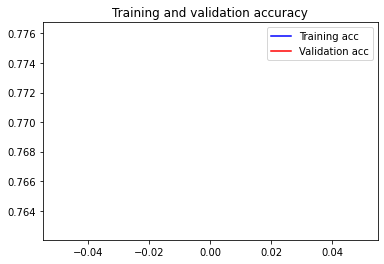

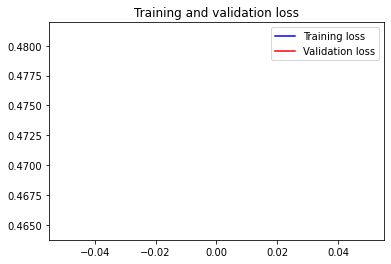

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9733065366744995,
 'elapsed_time': 0.08148622512817383}

In [ ]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.4831560254096985,
 'elapsed_time': 0.07238101959228516}

In [ ]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.021119922399520874,
 'elapsed_time': 0.08184218406677246}

In [ ]:
predict("Bad guys")

{'label': 'NEGATIVE',
 'score': 0.08120599389076233,
 'elapsed_time': 0.07676076889038086}

In [ ]:
predict("fuck u all")

{'label': 'NEGATIVE',
 'score': 0.25452369451522827,
 'elapsed_time': 0.07674908638000488}

In [ ]:
predict("I'm going under and this time I fear there's no one to save me")

{'label': 'NEGATIVE',
 'score': 0.3585672676563263,
 'elapsed_time': 0.07496809959411621}

In [ ]:
#Save model
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-28 23:00:56,152 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-28 23:00:56,153 : INFO : not storing attribute vectors_norm
2020-11-28 23:00:56,154 : INFO : not storing attribute cum_table
2020-11-28 23:00:56,537 : INFO : saved model.w2v


In [ ]:
model.save("model_epoc3.h5")

In [ ]:
import json

with open("/content/drive/MyDrive/ColabNotebooks/wdps/books_dict_no_entities.json", 'r') as file:
  dict = json.load(file)

dict

Output hidden; open in https://colab.research.google.com to view.